This Notebook contains an example of using the given VaLLA implementation over 1D regression datasets.

# Imports

In [1]:
# Notebook reload options
%load_ext autoreload
%autoreload 2

In [2]:

# Global Imports
import numpy as np
import torch
import pandas as pd
from torch.utils.data import DataLoader
import sys
from time import process_time as timer
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.cluster.vq import kmeans2

# Local Imports
sys.path.append("..")
from utils.pytorch_learning import fit_map, fit, forward
from src.valla import VaLLARegressionRBF, VaLLARegression
from src.ella import ELLA_Regression
from utils.models import get_mlp, create_ad_hoc_mlp
from laplace import Laplace

from utils.dataset import get_dataset

# Experimental settings

Theese are the parameters that determine the experiments. Most of these values are set to their default value. Please refer to `utils/process_flass.py` to know more about each parameter.

In [3]:
params = {
        "num_inducing": 20,
        "bnn_structure": [50, 50],
        "MAP_lr": 0.001,
        "MAP_iterations": 3000,
        "lr": 0.001,
        "iterations": 20000,
        "activation": torch.nn.Tanh,
        "device": "cpu",
        "dtype": torch.float64,
        "seed": 2147483647,
        "bb_alpha": 0,
        "prior_std": 1,
        "ll_std": 1
}

Set seed for reproductibility.

In [4]:
torch.manual_seed(params["seed"])

Load Dataset and desired split.

In [5]:
dataset = get_dataset("synthetic2")
train_dataset, train_test_dataset, test_dataset = dataset.get_split()

Number of samples:  400
Input dimension:  1
Label dimension:  1
Labels mean value:  0
Labels standard deviation:  1


Create Data loaders for training and test partitions.

In [6]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
train_test_loader = DataLoader(train_test_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# MAP Learning

In [7]:
f = get_mlp(
    train_dataset.inputs.shape[1],
    train_dataset.targets.shape[1],
    params["bnn_structure"],
    params["activation"],
    device=params["device"],
    dtype=params["dtype"],
)

# Define optimizer and compile model
opt = torch.optim.Adam(f.parameters(), lr=params["MAP_lr"])
criterion = torch.nn.MSELoss()

# Set the number of training samples to generate
# Train the model
start = timer()

loss = fit_map(
    f,
    train_loader,
    opt,
    criterion=torch.nn.MSELoss(),
    use_tqdm=True,
    return_loss=True,
    iterations=12000,
    device=params["device"],
)
end = timer()

Sequential(
  (0): Linear(in_features=1, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): Tanh()
  (4): Linear(in_features=50, out_features=1, bias=True)
)


Training :  20%|█▉        | 2367/12000 [00:15<01:03, 151.41 iteration/s]

Training : 100%|██████████| 12000/12000 [01:13<00:00, 163.52 iteration/s]


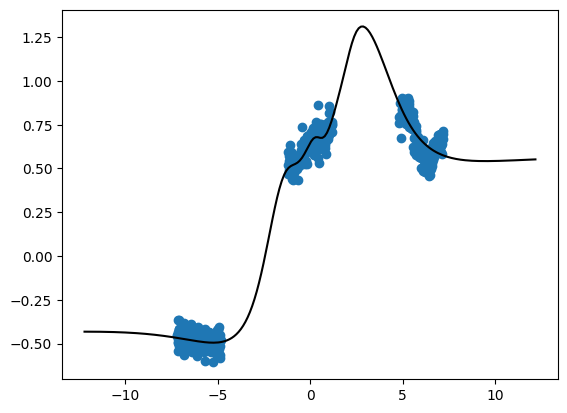

In [8]:

plt.scatter(train_dataset.inputs, 
                train_dataset.targets, 
                label="Training points")



sort = np.argsort(test_dataset.inputs.flatten())


plt.plot(
    test_dataset.inputs.flatten()[sort],
    f(torch.tensor(test_dataset.inputs)).detach().numpy().flatten()[sort],
    label="Predictions",
    color="black",
)
plt.show()

In [9]:
def distribution_plot(model_predictive, name = None):
    plt.rcParams["pdf.fonttype"] = 42
    plt.figure(figsize=(16,7))
    mean, var = model_predictive(torch.tensor(test_dataset.inputs, dtype = params["dtype"]))
    mean = mean.detach().numpy()
    var = var.detach().numpy()
    std = np.sqrt(var).flatten()
    sort = np.argsort(test_dataset.inputs.flatten())

    fig = plt.scatter(train_dataset.inputs, 
                    train_dataset.targets, 
                    color = "black")

    plt.plot(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort],
        color="cornflowerblue",
    )
    plt.fill_between(
        test_dataset.inputs.flatten()[sort],
        mean.flatten()[sort] - 2 * std[sort],
        mean.flatten()[sort] + 2 * std[sort],
        alpha=0.2,
        color="cornflowerblue",
    )

    #plt.axis('off')
    plt.ylim(-1. ,2)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig("../demos/plots/" + name+ ".pdf", format="pdf", bbox_inches='tight')
    plt.show()

In [31]:
Z = kmeans2(train_dataset.inputs, 10, 
            minit="points", seed=params["seed"])[0]


In [32]:
class VaLLARegressionRBF(VaLLARegression):
    def __init__(
        self,
        net,
        Z,
        prior_std,
        num_data,
        output_dim,
        log_variance=-5,
        track_inducing_locations=False,
        trainable_prior=True,
        inducing_classes=None,
        y_mean=0.0,
        y_std=1.0,
        alpha=0.5,
        device=None,
        dtype=torch.float64,
    ):
        super().__init__(
            net,
            Z,
            prior_std,
            num_data,
            output_dim,
            log_variance,
            track_inducing_locations,
            trainable_prior,
            inducing_classes,
            y_mean,
            y_std,
            alpha,
            device,
            dtype,
        )

        self.length_scale = torch.ones(Z.shape[1], device=device, dtype=dtype)
        self.length_scale = torch.nn.Parameter(self.length_scale)
        self.initial_length_scale = torch.ones(Z.shape[1], device=device, dtype=dtype)
        self.initial_log_prior_std = torch.tensor(np.log(prior_std), device=self.device, dtype = self.dtype)

    def rbf(self, X, Z):
        X = X / self.length_scale
        Z = Z / self.length_scale

        dist = torch.cdist(X, Z) ** 2

        l = 2
        K = torch.exp(self.log_prior_std) ** 2 * torch.exp(-dist / l)
        return K

    def rbf_prior(self, X, Z):
        X = X / self.length_scale
        Z = Z / self.length_scale

        dist = torch.cdist(X, Z) ** 2

        K = torch.exp(self.log_prior_std) ** 2 *torch.exp(-dist/2)
        return K

    def compute_kernels(self, X):
        Kx_diag = torch.diagonal(self.rbf(X, X)).unsqueeze(-1).unsqueeze(-1)
        Kxz = self.rbf(X, self.inducing_locations).unsqueeze(-1)
        Kzz = self.rbf(self.inducing_locations, self.inducing_locations)

        F_mean = self.net(X)

        return F_mean, Kx_diag, Kxz, Kzz

    def compute_KL(self):
        """
        Computes the Kulback-Leibler divergence between the variational distribution
        and the prior.
        """
        Kz = self.rbf(self.inducing_locations, self.inducing_locations)

        # Transform flattened cholesky decomposition parameter into matrix
        L = torch.eye(self.num_inducing, dtype=self.dtype, device=self.device)
        li, lj = torch.tril_indices(self.num_inducing, self.num_inducing)
        # Shape (num_inducing, num_inducing)
        L[li, lj] = self.L

        # Compute auxiliar matrices
        # Shape [num_inducing, num_inducing]
        # H = I + L^T @ self.Kz @ L
        I = torch.eye(self.num_inducing, dtype=self.dtype, device=self.device)
        H = I + torch.einsum("mn, ml, lk -> nk", L, Kz, L)
        # Shape [num_inducing, num_inducing]
        # A = L @ H^{-1} @ L^T
        # self.A = torch.einsum("nm, ml, kl -> nk", L, torch.inverse(self.H), L)
        A = L @ torch.linalg.solve(H, L.T)

        log_det = torch.logdet(H)
        trace = torch.sum(torch.diagonal(Kz @ A))
        KL = 0.5 * log_det - 0.5 * trace
        return torch.sum(KL)


In [45]:
valla = VaLLARegressionRBF(
    f,
    Z,
    alpha=1,
    prior_std=1,
    log_variance=-5,
    num_data=train_dataset.inputs.shape[0],
    output_dim=1,
    track_inducing_locations=True,
    y_mean=train_dataset.targets_mean,
    y_std=train_dataset.targets_std,
    device=params["device"],
    dtype=params["dtype"],
)
valla.freeze_prior()
valla.length_scale.requires_grad = False

Initializing inducing classes with 1 different classes


Start training.

In [46]:
def train_and_plot(iters):
    opt = torch.optim.Adam(valla.parameters(recurse = False), lr=0.01)

    loss = fit(
        valla,
        train_loader,
        opt,
        use_tqdm=True,
        return_loss=True,
        iterations=iters,
        device=params["device"],
    )
    distribution_plot(valla.predict_y)
    return loss

Training :   0%|          | 0/1000 [00:00<?, ? iteration/s]

Training : 100%|██████████| 1000/1000 [00:08<00:00, 115.27 iteration/s]


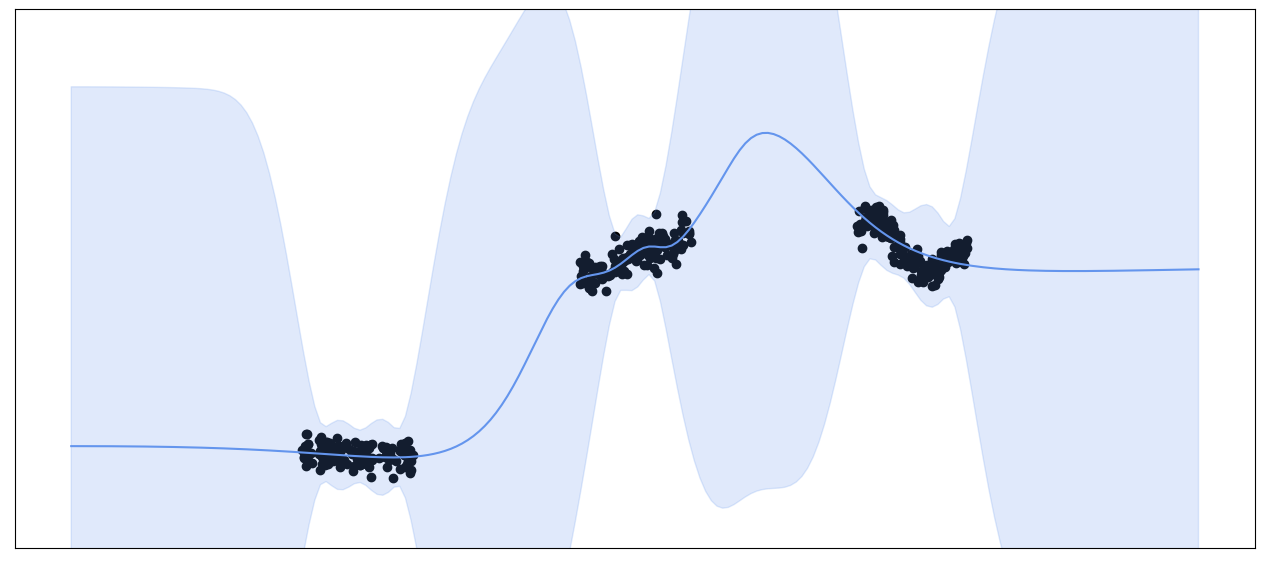

In [47]:
loss = train_and_plot(1000)


In [28]:
valla.print_variables(
)


---- MODEL PARAMETERS ----
 log_prior_std: ()
                [-0.09593682]
 inducing_locations: (10, 1)
                     [-5.08472671 -0.57295878 ... -7.02127211  0.59781972]
 L: (55)
    [ 1.72598836 -1.29900154 ... -2.4707195   1.74649107]
 log_variance: ()
               [-3.23866733]
 length_scale: (1)
               [1.2676755]
 NET
   0
     weight: (50, 1)
             [ 0.36060154  0.62656319 ...  0.3979013  -0.30136535]
     bias: (50)
           [ 0.38815147 -0.61465355 ... -0.20043015  0.81398335]
   2
     weight: (50, 50)
             [ 0.03504224 -0.082246   ... -0.05194333  0.03450862]
     bias: (50)
           [ 0.04814222 -0.17342346 ...  0.03023803 -0.00197269]
   4
     weight: (1, 50)
             [-0.00289498 -0.16534901 ... -0.14013513 -0.05735488]
     bias: (1)
           [-0.06210344]

---------------------------




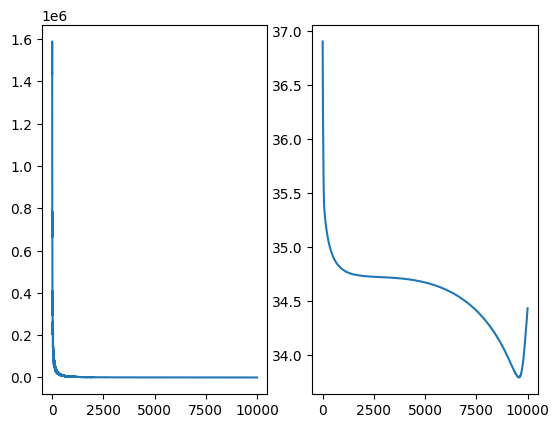

In [16]:
fig, axis = plt.subplots(1, 2)
axis[0].plot(valla.ell_history)
axis[1].plot(valla.kl_history)
plt.show()